In [ ]:
## 라이브러리 정의
import torch
import torch.nn as nn

## 네트워크 구축하기
class UNet(nn.Module):
    def __init__(self,classes=1):
        super(UNet, self).__init__()

        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size, stride=stride, padding=padding,
                                 bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers)

            return cbr

        # Contracting path
        self.enc1_1 = CBR2d(in_channels=1, out_channels=64)
        self.enc1_2 = CBR2d(in_channels=64, out_channels=64)

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = CBR2d(in_channels=64, out_channels=128)
        self.enc2_2 = CBR2d(in_channels=128, out_channels=128)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = CBR2d(in_channels=128, out_channels=256)
        self.enc3_2 = CBR2d(in_channels=256, out_channels=256)

        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.enc4_1 = CBR2d(in_channels=256, out_channels=512)
        self.enc4_2 = CBR2d(in_channels=512, out_channels=512)

        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.enc5_1 = CBR2d(in_channels=512, out_channels=1024)

        # Expansive path
        self.dec5_1 = CBR2d(in_channels=1024, out_channels=512)

        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec4_2 = CBR2d(in_channels=2 * 512, out_channels=512)
        self.dec4_1 = CBR2d(in_channels=512, out_channels=256)

        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec3_2 = CBR2d(in_channels=2 * 256, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128)

        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec2_2 = CBR2d(in_channels=2 * 128, out_channels=128)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64)

        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec1_2 = CBR2d(in_channels=2 * 64, out_channels=64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)

        self.fc = nn.Conv2d(in_channels=64, out_channels=7, kernel_size=1, stride=1, padding=0, bias=True)

    def forward(self, x): # x는 input
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)

        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        enc5_1 = self.enc5_1(pool4)

        dec5_1 = self.dec5_1(enc5_1)

        unpool4 = self.unpool4(dec5_1)
        cat4 = torch.cat((enc4_2,unpool4), dim=1)
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)

        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((enc3_2,unpool3), dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((enc2_2,unpool2), dim=1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)

        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((enc1_2,unpool1), dim=1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)

        x = self.fc(dec1_1)

        return x

In [ ]:
## 라이브러리
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms
from skimage.transform import resize
import cv2

## 데이터 로더를 구현하기
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform

        lst_data = os.listdir(self.data_dir)

        lst_label = [f for f in lst_data if f.startswith('label')]
        lst_input = [f for f in lst_data if f.startswith('input')]
        lst_label.sort()
        lst_input.sort()
        self.lst_label = lst_label
        self.lst_input = lst_input

    def __len__(self):
        return len(self.lst_input)

    def __getitem__(self, index):
        label = np.load(os.path.join(self.data_dir, self.lst_label[index]))
        input = np.load(os.path.join(self.data_dir, self.lst_input[index]))

        #0~1사이로 normalize
        label = label
        input = input/255.0

        if label.ndim == 2:
            label = label[:, :, np.newaxis]
        if input.ndim == 2:
            input = input[:, :, np.newaxis]

        data = {'input': input, 'label': label}

        if self.transform:
            data = self.transform(data)

        return data

class Dataset_test(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform

        lst_data = os.listdir(self.data_dir)

        lst_input = [f for f in lst_data if f.startswith('input')]
        lst_input.sort()
        self.lst_input = lst_input

    def __len__(self):
        return len(self.lst_input)

    def __getitem__(self, index):
        input = np.load(os.path.join(self.data_dir, self.lst_input[index]))

        #0~1사이로 normalize
        input = input/255.0

        if input.ndim == 2:
            input = input[:, :, np.newaxis]

        data = {'input': input}

        if self.transform:
            data = self.transform(data)

        return data

# class Dataset_test(torch.utils.data.Dataset):
#     def __init__(self, data_dir, transform=None):
#         self.data_dir = data_dir
#         self.transform = transform
#
#         lst_data = os.listdir(self.data_dir)
#
#         lst_input = lst_data
#         lst_input.sort()
#         self.lst_input = lst_input
#
#     def __len__(self):
#         return len(self.lst_input)
#
#     def __getitem__(self, index):
#         input = np.load(os.path.join(self.data_dir, self.lst_input[index]))
#
#         #0~1사이로 normalize
#         input = input/255.0
#
#         if input.ndim == 2:
#             input = input[:, :, np.newaxis]
#
#         data = {'input': input}
#
#         if self.transform:
#             data = self.transform(data)
#
#         return data

## 트랜스폼 구현하기
class ToTensor(object):
    def __call__(self, data):
        label, input = data['label'], data['input']

        input = input.transpose((2, 0, 1)).astype(np.float32)
        label = label.transpose((2, 0, 1)).astype(np.float32)

        data = {'input': torch.from_numpy(input), 'label': torch.from_numpy(label)}

        return data

class Normalization(object):
    def __init__(self, mean=0.5, std=0.5):
        self.mean = mean
        self.std = std

    def __call__(self, data):
        label, input = data['label'], data['input']

        input = (input - self.mean) / self.std

        data = {'input': input, 'label': label}

        return data

class Resize(object):
    def __init__(self, size=(256,256)):
        self.size = size
    def __call__(self, data):
        label, input = data['label'], data['input']

        #input= resize(input, self.size)
        #label= resize(label, self.size)
        input = cv2.resize(input, dsize=self.size, interpolation=cv2.INTER_CUBIC)[:, :, np.newaxis]
        label = cv2.resize(label, dsize=self.size, interpolation=cv2.INTER_CUBIC)

        data = {'input': input, 'label': label}

        return data

class RandomFlip(object):
    def __call__(self, data):
        label, input = data['label'], data['input']

        if np.random.rand() > 0.5:
            label = np.fliplr(label)
            input = np.fliplr(input)

        elif np.random.rand() > 0.5:
            label = np.flipud(label)
            input = np.flipud(input)

        data = {'label': label, 'input': input}

        return data

class RandomRotation(object):
    def __call__(self, data):
        label, input = data['label'], data['input']

        if np.random.rand() > 0.5:
            label = np.rot90(label,k=1,axes=(0, 1))
            input = np.rot90(input,k=1)

        elif np.random.rand() > 0.5:
            label = np.rot90(label, k=3, axes=(0, 1))
            input = np.rot90(input, k=3)

        data = {'label': label, 'input': input}

        return data

## test 트랜스폼 구현하기
class ToTensor_test(object):
    def __call__(self, data):
        input = data['input']

        input = input.transpose((2, 0, 1)).astype(np.float32)

        data = {'input': torch.from_numpy(input)}

        return data

class Normalization_test(object):
    def __init__(self, mean=0.5, std=0.5):
        self.mean = mean
        self.std = std

    def __call__(self, data):
        input = data['input']

        input = (input - self.mean) / self.std

        data = {'input': input}

        return data

class Resize_test(object):
    def __init__(self, size=(256,256)):
        self.size = size
    def __call__(self, data):
        input = data['input']


        input = cv2.resize(input, dsize=self.size, interpolation=cv2.INTER_CUBIC)[:, :, np.newaxis]

        data = {'input': input}

        return data

In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
#val
transform = transforms.Compose([Normalization(mean=0.5, std=0.5), Resize(),RandomFlip(),RandomRotation(),ToTensor()])
dataset_train = Dataset(data_dir=os.path.join('/content/drive/Othercomputers/notebook/lumbar/datasets', 'val'), transform=transform)
loader_val = DataLoader(dataset_train, batch_size=16, shuffle=False, pin_memory=True)


model = UNet()
fn_loss = nn.MultiLabelSoftMarginLoss()

In [ ]:
for batch, data in enumerate(loader_val, 1):
    # forward pass
    label = data['label']
    input = data['input']
    pred = model(input)
    loss = fn_loss(pred, label)
    print(loss)
    print(label.shape)
    print(input.shape)

In [ ]:
#test
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets

transform = transforms.Compose([Normalization_test(mean=0.5, std=0.5), Resize_test(), ToTensor_test()])
dataset_test = Dataset_test(data_dir=os.path.join('/content/drive/Othercomputers/notebook/lumbar/datasets', 'test'),transform=transform)
lst_data = os.listdir(os.path.join('/content/drive/Othercomputers/notebook/lumbar/datasets', 'test'))
loader_test = DataLoader(dataset_test, batch_size=16, shuffle=False, num_workers=8, pin_memory = True)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
num_data_test = len(dataset_test)
num_batch_test = np.ceil(num_data_test / 16)
for batch, data in enumerate(loader_test, 1):
    # forward pass
    input = data['input'].to(device)
    output = model(input)
    print("TEST: BATCH %04d / %04d |" %(batch, num_batch_test))
    print(input.shape, input.type)
    print(output.shape , output.type)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


TEST: BATCH 0001 / 0002 |
torch.Size([16, 1, 256, 256]) <built-in method type of Tensor object at 0x7f8dbad86350>
torch.Size([16, 7, 256, 256]) <built-in method type of Tensor object at 0x7f8d98a71a70>
TEST: BATCH 0002 / 0002 |
torch.Size([4, 1, 256, 256]) <built-in method type of Tensor object at 0x7f8d98a980b0>
torch.Size([4, 7, 256, 256]) <built-in method type of Tensor object at 0x7f8d98a62dd0>


In [ ]:
fn_tonumpy = lambda x: x.to('cpu').detach().numpy().transpose(0, 2, 3, 1) #from tensor to numpy
fn_class = lambda x: 1.0 * (x > 0.5) #classification() using thresholding( p=0.5) 네트워크 output을 binary class로 변환

In [ ]:
pred = fn_tonumpy(fn_class(output))
print(pred.shape)
print(pred.min())
print(pred.max())

In [ ]:
pred_new = pred.astype(np.uint8)
print(pred_new.dtype)
print(pred.dtype)

In [ ]:
k=pred

In [ ]:
input.shape

torch.Size([4, 1, 256, 256])

In [ ]:
input[0].shape

torch.Size([1, 256, 256])

In [ ]:
output[0].shape

torch.Size([7, 256, 256])

In [ ]:
k.shape

(4, 256, 256, 7)

In [ ]:
k.shape[-1]

7

In [ ]:
k[0].shape

(256, 256, 7)

In [ ]:
k[0][...,6:7].shape

(256, 256, 1)

In [ ]:
ok=k[0]

In [ ]:
ok_new = cv2.resize(ok, dsize=(516,1028), interpolation=cv2.INTER_NEAREST)

In [ ]:
ok_new.shape

(1028, 516, 7)

In [ ]:
ok_new.min()

0.0

In [ ]:
ok_new.max()

1.0

In [ ]:
k.min()

0.0

In [ ]:
k.max()

1.0

In [ ]:
example=np.load('/content/drive/Othercomputers/notebook/lumbar/datasets/val/label_006.npy')

In [ ]:
example.shape

(3268, 2756, 7)

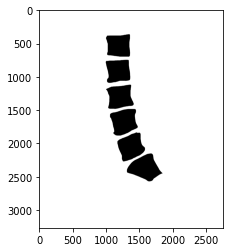

In [ ]:
plt.imshow(example[...,6:7].squeeze(), cmap='gray')

In [ ]:
cha_ex = cv2.resize(example[...,6:7], dsize=(256,256), interpolation=cv2.INTER_CUBIC)

In [ ]:
cha_ex.shape

(256, 256, 7)

TypeError: ignored

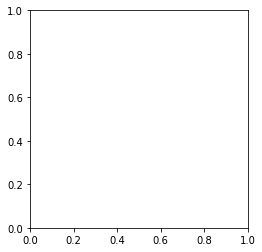

In [ ]:
plt.imshow(cha_ex[...,6:7].squeeze(), cmap='gray')

In [ ]:
ex_new = cv2.resize(cha_ex, dsize=(2756,3268), interpolation=cv2.INTER_NEAREST)

In [ ]:
ex_new.shape

(3268, 2756)

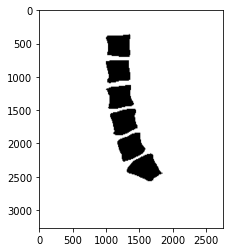

In [ ]:
plt.imshow(ex_new, cmap='gray')

In [ ]:
ex_new.min()

0

In [ ]:
ex_new.max()

1

In [ ]:
ex_new.dtype

dtype('uint8')

In [ ]:
k[0][...,6:7].shape

(256, 256, 1)

In [ ]:
example=np.load('/content/drive/Othercomputers/notebook/lumbar/datasets/val/label_006.npy')
cha_ex = cv2.resize(example, dsize=(256,256), interpolation=cv2.INTER_CUBIC)

In [ ]:
cha_ex.shape

(256, 256, 7)

In [ ]:
output_new=[]
## 이미지 resize
for ii in range(cha_ex.shape[-1]):
    ex_new = cv2.resize(cha_ex[...,ii:ii+1], dsize=(2756, 3268), interpolation=cv2.INTER_NEAREST)
    output_new.append(ex_new)
a = np.array(output_new)

In [ ]:
a.dtype

dtype('uint8')

In [ ]:
a.shape

(7, 3268, 2756)

In [ ]:
b=a.transpose(1, 2, 0)

In [ ]:
b.squeeze().shape

(3268, 2756, 7)

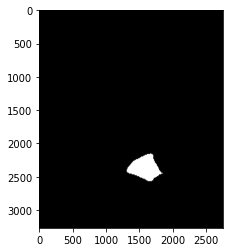

In [ ]:
plt.imshow(b[...,5:6].squeeze(), cmap='gray')

In [ ]:
b=(0,1)

In [ ]:
aTuple = (20, 10, 30, 80, 80, 70, 60, 100, 50, 40)
revered_list = list(reversed(aTuple))
print(tuple(revered_list)) # (40, 50, 100, 60, 70, 80, 80, 30, 10, 20)
print(aTuple) # (20, 10, 30, 80, 80, 70, 60, 100, 50, 40)

(40, 50, 100, 60, 70, 80, 80, 30, 10, 20)
(20, 10, 30, 80, 80, 70, 60, 100, 50, 40)


In [ ]:
b=(0,1)
revered_list = list(reversed(b))
b=tuple(revered_list)
print(b)

(1, 0)
